<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# GOES CIRA Product Writer
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/GOES_CIRA_preview.png" alt="GOES East Geocolor composite image" style="height: 300px;"></div>


# Objectives

* Use python-awips to connect to an EDEX server
* Define and filter the data request specifically for new [CIRA GOES16 data products](#Additional-Documentation)
* Resize the products to their native resolution
* Write the individual bands (channels) locally
* Combine and write the RGB product locally

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Initial-Setup" data-toc-modified-id="Initial-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial Setup</a></span><ul class="toc-item"><li><span><a href="#EDEX-Connection" data-toc-modified-id="EDEX-Connection-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>EDEX Connection</a></span></li><li><span><a href="#Parameter-Definition" data-toc-modified-id="Parameter-Definition-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Parameter Definition</a></span></li></ul></li><li><span><a href="#Function:-set_size()" data-toc-modified-id="Function:-set_size()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Function: set_size()</a></span></li><li><span><a href="#Function:-write_img()" data-toc-modified-id="Function:-write_img()-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Function: write_img()</a></span></li><li><span><a href="#Get-the-Data-and-Write-it-Out!" data-toc-modified-id="Get-the-Data-and-Write-it-Out!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get the Data and Write it Out!</a></span><ul class="toc-item"><li><span><a href="#Filter-the-Data" data-toc-modified-id="Filter-the-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Filter the Data</a></span></li><li><span><a href="#Define-Output-Location" data-toc-modified-id="Define-Output-Location-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Define Output Location</a></span></li><li><span><a href="#Write-Out-GOES-Images" data-toc-modified-id="Write-Out-GOES-Images-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Write Out GOES Images</a></span></li></ul></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Related-Notebooks" data-toc-modified-id="Related-Notebooks-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Related Notebooks</a></span></li><li><span><a href="#Additional-Documentation" data-toc-modified-id="Additional-Documentation-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Additional Documentation</a></span></li></ul></li></ul></div>

## Imports

The imports below are used throughout the notebook.  Note the first import is coming directly from python-awips and allows us to connect to an EDEX server.  The subsequent imports are for data manipulation and visualization. 

In [1]:
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os

<a href="#top">Top</a>

---

## Initial Setup

### EDEX Connection

First we establish a connection to Unidata's public EDEX server.  With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to ***satellite***.

In [2]:
# Create an EDEX data request
# DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
DataAccessLayer.changeEDEXHost("149.165.156.89")
request = DataAccessLayer.newDataRequest()
request.setDatatype("satellite")

### Parameter Definition

After establishing the python-awips specific objects, we create a few other parameters that will be used for the data query based off of known values: projection, and extent.

In [3]:
# Create a projection for ECONUS and WCONUS
# Set up the projection using known parameters (from the netcdf of GOES products)
globe = ccrs.Globe(semimajor_axis=6378137.0, semiminor_axis=6356752.5, ellipse=None)
sat_h = 35785830.0
proj = ccrs.Geostationary(globe=globe, central_longitude=-75.0, satellite_height=sat_h, sweep_axis='x')

# Define the extents for ECONUS and WCONUS in goes native coords
# (originally taken from netcdf GOES data)
extent = (-3626751., 1382263.5, 1583666.1, 4588674.)

<a href="#top">Top</a>

---

## Function: set_size()

Here we're defining a function that will allow us to pass in the dimensions of the output file we desire in pixels.  Default Python methods require the size to be set in inches, which is confusing in our case, since we know what the size of GOES images are in pixels.  Also, default Python functions add a padding when creating figures, and we don't want that.  

This function allows the exact final image to be specified based in pixels, with no padding or buffers.

In [4]:
def set_size(w,h, plt):
    """ w, h: width, height in pixels """
    
    # Convert from pixels to inches
    DPI = plt.figure().get_dpi()
    w = w/float(DPI)
    h = h/float(DPI)
    
    # Get the axes
    ax=plt.gca()

    # Remove the padding
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    
    # Set the final size
    ax.figure.set_size_inches(figw, figh)
    
    # Return the DPI, this is used when in the 
    # write_image() function
    return DPI

<a href="#top">Top</a>

---

## Function: write_img()


In [5]:
def write_img(data, name, proj, extent, reftime, footnote):
    
    # Specify the desired size, in pixels
#     px_width = 5000.0
#     px_height = 4000.0
    px_width = 500.0
    px_height = 400.0


    # Create the plot with proper projection, and set the figure size
    fig = plt.figure()
    DPI = set_size(px_width, px_height, plt)
    ax = plt.axes(projection=proj)
     
    # Draw GOES data
    ax.imshow(data, cmap='gray', transform=proj, extent=extent)

    # Add Coastlines and States
    ax.coastlines(resolution='50m', color='magenta', linewidth=1.0)
    ax.add_feature(cfeat.STATES, edgecolor='magenta', linewidth=1.0)
    ax.gridlines(color='cyan', linewidth=2.0, xlocs=np.arange(-180, 180, 10), linestyle=(0,(5,10)))

    # Create and draw the footnote if needed
    if footnote: 
        footnoteStr = '   CIRA-'+name[7:-4]+'-'+str(reftime)
        plt.annotate(str(footnoteStr), (0,0), (0, 0), xycoords='axes fraction', textcoords='offset points', va='top')
    
    # Write out the figure
    plt.savefig(name, dpi=DPI, bbox_inches='tight', pad_inches=0)

<a href="#top">Top</a>

---

## Get the Data and Write it Out!


### Filter the Data

Define exactly what data we want to be printing out.  This notebook is designed to loop through and print out multiple images, so here we can pick which images we're wanting to print out.  We're specifying ***ECONUS*** (for East CONUS), ***CLDSNOW***, ***DBRDUST***, and ***GEOCOLR*** (for the new CIRA products) and the ***three channels*** for the RBG composites.

<div class="alert-info">
<b>Tip:</b>  
More information could be gathered by looking at all the available location names (sectors), identifiers (entities), and parameters (channels).  To see those run the following lines of code after the dataType has been set to satellite on the request object:
</div>

```
## Print Available Location Names
print((DataAccessLayer.getAvailableLocationNames(request))
   
## Print Available Identifiers and Values
ids = DataAccessLayer.getOptionalIdentifiers(request)
print(ids)
for id in ids:
    print(id, DataAccessLayer.getIdentifierValues(request, id))
```

In [6]:
# Define Location names
sectors = ["ECONUS"]

# Define creatingEntity Identifiers
entities = ["CLDSNOW", "DBRDUST", "GEOCOLR"]

# Define parameters
ch1 = "CH-01-0.47um"
ch2 = "CH-02-0.64um"
ch3 = "CH-03-0.87um"
channels = [ch1, ch2, ch3]

### Define Output Location

Here we define a folder for where the satellite images will be written to.  The default directory is a new folder called 'output' that lives whereever this notebook lives.

<div class="alert-info">
<b>Tip:</b>  
If you specify the fully qualified path, it will no longer depend on where this notebook is located.  For example (for a Mac):
</div>

```
outputDir = '/Users/scarter/test_dir/output/'
```

In [7]:
# Define name of the desired end directory
outputDir = 'output/'

# Check to see if this folder exists
if not os.path.exists(outputDir):
    # If not, create the directory
    print('Creating new output directory: ',outputDir)
    os.makedirs(outputDir)
else:
    # If so, let the user know
    print('Output directory exists!')

Output directory exists!


### Write Out GOES Images



selected time: [<DataTime instance: 2021-05-28 06:16:14 >]
writing output3/GEOCOLR-ECONUS-CH-01-0.47um.png
writing output3/GEOCOLR-ECONUS-CH-02-0.64um.png
writing output3/GEOCOLR-ECONUS-CH-03-0.87um.png
writing GOES_CIRA_night_preview.png
Done!


<Figure size 432x288 with 0 Axes>

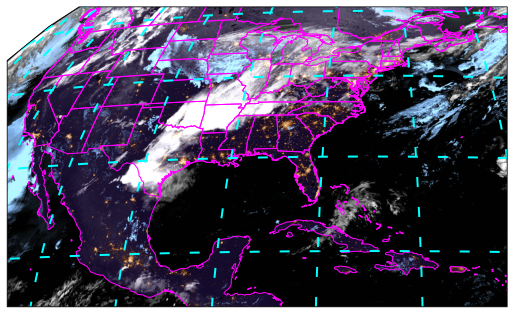

In [8]:
# First loop through the sectors (location names)
for sector in sectors:
    
    # Set the location on the request
    request.setLocationNames(sector)
    
    # Next loop through the Products (entities)
    for entity in entities:
        # Reset the time and channel variables since we're on a new product
        time = None
        R = None
        G = None
        B = None
        
        # Set the product
        request.addIdentifier("creatingEntity", entity)
        
        # Cycle through the channels (parameters)
        for channel in channels:
            request.setParameters(channel)
            
            # Set the time for this product if it hasn't been set
            # If it has been set, then we proceed with that value
            # so that all bands in for the one product are pulled
            # from the same time
            if(time is None):
                times = DataAccessLayer.getAvailableTimes(request)
                time = [times[-1]]
                print("selected time:", time)

            # Request the data from EDEX
            response = DataAccessLayer.getGridData(request, time)
            # Grab the actual data from the response
            grid = response[0]
            # Get the raw data from the response
            data = grid.getRawData()
            reftime = grid.getDataTime().getRefTime()
            
            # Set the R,G,B channel
            if(channel == ch1):
                B = data
            elif (channel == ch2):
                R = data
            elif (channel == ch3):
                G = data
            
            # Create the single channel name
            name = outputDir+entity+'-'+sector+'-'+channel+'.png'

            # Write out the single channel
            print('writing',name)
            write_img(data, name, proj, extent, reftime, False)
       
        # --- End of channel loop    
            
        # Create the RGB product
        # Apply range limits for each channel. RGB values must be between 0 and 1
        R = np.clip(R, 0, 1)
        G = np.clip(G, 0, 1)
        B = np.clip(B, 0, 1)
        RGB = np.dstack([R, G, B])
        
        # Create RGB name
        rgbName = outputDir+entity+'-'+sector+'-RGB.png'
        # Write out the RGB image
        print('writing', rgbName)
        write_img(RGB, rgbName, proj, extent, time, False)
        
    # --- End of entity loop
#--- End of sector loop
        
print('Done!')

<a href="#top">Top</a>

---

## See Also

### Related Notebooks

- [Satellite Imagery](http://unidata.github.io/python-awips/examples/generated/Satellite_Imagery.html)

### Additional Documentation

**CIRA Quick Guides**

- [DEBRA-Dust](https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_DEBRA-Dust_20210217.pdf)
- [Cloud-Snow](https://rammb.cira.colostate.edu/training/visit/quick_guides/GOES_Cloud_Snow_Discriminator_Quick_Guide_20190814.pdf)
- [GEOCOLOR](https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_CIRA_Geocolor_20171019.pdf)


**python-awips**

- [DataAccessLayer.changeEDEXHost()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.changeEDEXHost)
- [DataAccessLayer.newDataRequest()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.newDataRequest)
- [DataAccessLayer.getAvailableLocationNames()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.getAvailableLocationNames)
- [DataAccessLayer.getOptionalIdentifiers()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.getOptionalIdentifiers)
- [DataAccessLayer.getIdentifierValues()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.getIdentifierValues)
- [DataAccessLayer.getAvailableTimes()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.getAvailableTimes)
- [IDataRequest](http://unidata.github.io/python-awips/api/IDataRequest.html)

**matplotlib**

- [matplotlib.pyplot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
- [matplotlib.pyplot.axes()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axes.html)
- [matplotlib.pyplot.figure()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)

**numpy**

- [numpy.clip()](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)
- [numpy.dstack()](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html)

<a href="#top">Top</a>

---